Loaded dataset: 1 images, 1 person instances, 0 failed
(256, 192)
12 14
10 7
15 7
17 0
23 7
39 35
36 42
31 137
25 147
27 200
17 232
78 133
76 133
114 223
20 91
161 228
19 206
167 204
26 238
191 255
0 239
34 84
51 98
56 112
41 16
73 74
91 123
53 25
41 96
65 44
46 97
85 97
55 102


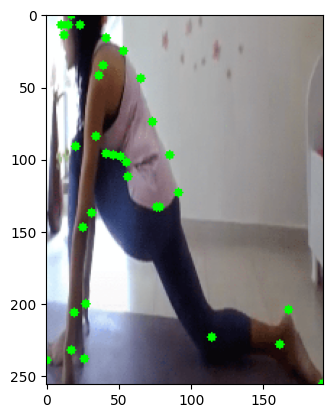

In [ ]:
# Check DataLoader for YOLOPoseDataset



from torch.utils.data import Dataset, DataLoader
import torch
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dataloader.yolo_dataset import YOLOPoseDataset

# Example usage with DataLoader
if __name__ == "__main__":
    dataset = YOLOPoseDataset(
        img_dir=r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\images",
        label_dir=r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\labels",
        input_size=(256, 192),
        num_joints=33,
        sigma=2
    )
    
    dataloader = DataLoader(
        dataset, 
        batch_size=16, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    # Test
    for batch in dataloader:
        img = batch['image']  # (B, 3, 256, 192)
        heatmaps = batch['heatmaps']  # (B, 33, 32, 24)
        mask = batch['mask']  # (B, 33, 1, 1)
        kpts = batch['kpts']  # (B, 33, 2)
        vis = batch['vis']  # (B, 33)
        
        img = img[0].permute(1, 2, 0).numpy().astype(np.float32)  # (256, 192, 3)
        de_norm_img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        
        img_cv2 = np.copy((de_norm_img * 255).astype(np.uint8))

        img_cv2 = np.ascontiguousarray(img_cv2)
        de_norm_kp = []
        print(dataset.input_size)
        for kpt in kpts[0]:
            de_norm_x = int(max(0, min(kpt[0].item() * dataset.input_size[1], dataset.input_size[1] - 1)))
            de_norm_y = int(max(0, min(kpt[1].item() * dataset.input_size[0], dataset.input_size[0] - 1)))
            print(de_norm_x, de_norm_y)
            cv2.circle(img_cv2, 
                       (int(de_norm_x), int(de_norm_y)), 
                       3, (0, 255, 0), -1)
            de_norm_kp.append((de_norm_x, de_norm_y))

        plt.imshow(img_cv2)
        plt.show()


Class: 0, BBox: (416, 265), (1320, 719)


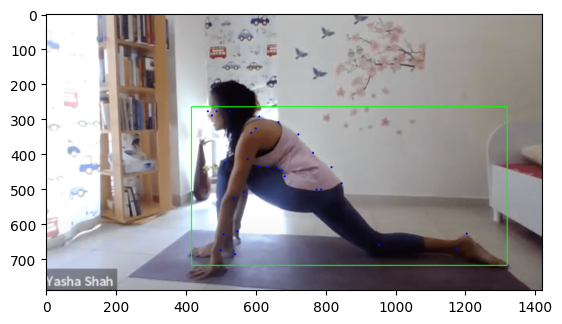

In [12]:
#visualize dataset 
import cv2
import matplotlib.pyplot as plt

image_path = r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\images\000000000048.png"
label_path = r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\labels\000000000048.txt"

with open(label_path, 'r') as f:
    lines = f.readlines()
img = cv2.imread(image_path)
h, w = img.shape[:2]
for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1])*w
    y_center = float(parts[2])*h
    width = float(parts[3])*w
    height = float(parts[4])*h

    keypoints = []
    for i in range(5, len(parts), 3):
        kp_x = float(parts[i])*w
        kp_y = float(parts[i+1])*h
        keypoints.append((kp_x, kp_y))
    
    for kp in keypoints:
        cv2.circle(img, (int(kp[0]), int(kp[1])), 3, (255, 0, 0), -1)


    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    print(f"Class: {class_id}, BBox: ({x1}, {y1}), ({x2}, {y2})")
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    

 



In [1]:
# ====== 2. SKELETON (MediaPipe-like 33 points) ======
# Pairs (i, j) to draw limbs. This is a reasonable set for 33-pt layouts.
SKELETON = [
    (9,11),(11,13),(13,15),           # left arm: shoulder-elbow-wrist
    (10,12),(12,14),(14,16),          # right arm
    (9,10),                           # shoulders
    (15,16),(15,23),(16,24),          # hips & torso
    (23,25),(25,27),(27,29),(29,31),  # left leg chain
    (24,26),(26,28),(28,30),(30,32),  # right leg chain
    (31,21),(32,22),(21,19),(22,20),  # feet/heels/ankles (approx)
    (0,9),(0,10),                     # nose to shoulders
    (1,2),(2,3),(4,5),(5,6),          # eyes chains
    (7,9),(8,10)                      # ears to shoulders
]

def denorm_xy_to_hm(xy_norm, hm_size):
    """xy_norm: (N,2) in [0,1]; return pixel coordinates in heatmap space"""
    xy = xy_norm.copy()
    xy[:,0] = xy[:,0] * (hm_size-1)
    xy[:,1] = xy[:,1] * (hm_size-1)
    return xy

def draw_keypoints(img_rgb, kpts_xy_norm, score=None, title=None):
    h, w = img_rgb.shape[:2]
    xs = (kpts_xy_norm[:,0] * w).astype(int)
    ys = (kpts_xy_norm[:,1] * h).astype(int)
    vis = np.ones(len(xs), dtype=bool) if score is None else (score>0)

    img = img_rgb.copy()
    # limbs
    for i,j in SKELETON:
        if i < len(xs) and j < len(xs) and vis[i] and vis[j]:
            cv2.line(img, (xs[i],ys[i]), (xs[j],ys[j]), (0,255,0), 2)
    # points
    for i,(x,y) in enumerate(zip(xs,ys)):
        if vis[i]:
            cv2.circle(img, (x,y), 3, (255,0,0), -1)
    if title:
        img = img.copy()
        cv2.putText(img, title, (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)
    return img


In [3]:
#new heatmap
# ====== 3. HEATMAP UTILS ======
from torchvision import transforms
from pathlib import Path
import random
from torch.utils.data import Dataset

def gaussian2d(h, w, cx, cy, sigma):
    xs = np.arange(w, dtype=np.float32)
    ys = np.arange(h, dtype=np.float32)[:, None]
    return np.exp(-((xs - cx) ** 2 + (ys - cy) ** 2) / (2 * sigma * sigma))

def kpts_to_heatmaps(kpts_xy_norm, visibility, hm_size, sigma=2.0):
    K = kpts_xy_norm.shape[0]
    Hm = Wm = hm_size
    heatmaps = np.zeros((K, Hm, Wm), dtype=np.float32)
    mask = np.zeros((K, 1, 1), dtype=np.float32)

    kpts_hm = denorm_xy_to_hm(kpts_xy_norm.copy(), hm_size)
    for k in range(K):
        v = visibility[k]
        if v > 0:
            cx, cy = kpts_hm[k]
            if 0 <= cx < Wm and 0 <= cy < Hm:
                heatmaps[k] = gaussian2d(Hm, Wm, cx, cy, sigma)
                mask[k, 0, 0] = 1.0
    return heatmaps, mask


# ====== 3b. DATASET (reads YOLO-pose .txt) ======
import unicodedata

class PoseHeatmapDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, list_file=None,
                 img_size=256, hm_size=64, sigma=2.0, aug=False):
        self.img_dir = Path(img_dir)
        self.lbl_dir = Path(lbl_dir)
        self.img_size = img_size
        self.hm_size = hm_size
        self.sigma = sigma
        self.aug = aug

          # ===== Đọc toàn bộ định dạng ảnh phổ biến =====
        exts = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"]
        img_files = []
        for e in exts:
            img_files.extend(list(self.img_dir.glob(e)))

        if list_file and Path(list_file).exists():
            with open(list_file) as f:
                rels = [ln.strip() for ln in f if ln.strip()]
            self.images = [Path(ln).name for ln in rels]
        else:
            self.images = sorted([p.name for p in img_files])
        # Transform an toàn
        self.to_tensor = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def safe_load_image(self, path):
        """Đọc ảnh, trả None nếu lỗi"""
        img = cv2.imread(str(path))
        if img is None or img.size == 0:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.ascontiguousarray(img, dtype=np.uint8)
        if img.ndim != 3 or img.shape[2] != 3:
            return None
        return img

    def safe_load_label(self, path):
        """Đọc nhãn, trả None nếu lỗi"""
        try:
            with open(path, 'r') as f:
                toks = list(map(float, f.readline().split()))
            if len(toks) < 5 + 33 * 3:
                return None
            kpt_raw = np.array(toks[5:], dtype=np.float32).reshape(-1, 3)
            return kpt_raw
        except Exception:
            return None

    def __getitem__(self, idx):
        import difflib
    
        name = self.images[idx]
        img_path = self.img_dir / name
        label_path = self.lbl_dir / f"{Path(name).stem}.txt"
    
        # fuzzy match nếu thiếu label
        if not label_path.exists():
            lbl_files = [p.stem for p in self.lbl_dir.glob("*.txt")]
            match = difflib.get_close_matches(Path(name).stem, lbl_files, n=1, cutoff=0.9)
            if match:
                label_path = self.lbl_dir / f"{match[0]}.txt"
            else:
                print(f" Skip (no label): {name}")
                return self.__getitem__((idx + 1) % len(self.images))
    
        # đọc ảnh & label
        img = self.safe_load_image(img_path)
        if img is None:
            print(f" Skip (bad image): {name}")
            return self.__getitem__((idx + 1) % len(self.images))
    
        try:
            toks = list(map(float, open(label_path).read().split()))
            if len(toks) < 5 + 33*3:
                raise ValueError("Label thiếu keypoint")
        except Exception as e:
            print(f" Skip (bad label): {name}")
            return self.__getitem__((idx + 1) % len(self.images))
    
        # --- Tách dữ liệu ---
        cls, xc, yc, w, h = toks[:5]
        kpt_raw = np.array(toks[5:], dtype=np.float32).reshape(-1, 3)
        kpts_xy = kpt_raw[:, :2]
        v = kpt_raw[:, 2]
    
        # --- Crop vùng người ---
        H, W = img.shape[:2]
        x1 = int((xc - w / 2) * W)
        y1 = int((yc - h / 2) * H)
        x2 = int((xc + w / 2) * W)
        y2 = int((yc + h / 2) * H)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W, x2), min(H, y2)
        if x2 <= x1 or y2 <= y1:
            print(f" Skip (invalid bbox): {name}")
            return self.__getitem__((idx + 1) % len(self.images))
    
        img_crop = img[y1:y2, x1:x2]
        crop_H, crop_W = img_crop.shape[:2]
    
        # --- Chuẩn hóa keypoint theo vùng crop ---
        kpts_px = np.copy(kpts_xy)
        kpts_px[:, 0] = kpts_px[:, 0] * W - x1
        kpts_px[:, 1] = kpts_px[:, 1] * H - y1
        kpts_xy_new = np.copy(kpts_px)
        kpts_xy_new[:, 0] = np.clip(kpts_xy_new[:, 0] / crop_W, 0, 1)
        kpts_xy_new[:, 1] = np.clip(kpts_xy_new[:, 1] / crop_H, 0, 1)
    
        # --- Augmentation ---
        if self.aug:
            if random.random() < 0.5:
                img_crop = cv2.flip(img_crop, 1)
                kpts_xy_new[:, 0] = 1.0 - kpts_xy_new[:, 0]
            if random.random() < 0.3:
                img_crop = cv2.GaussianBlur(img_crop, (3, 3), 0)
    
        # --- Tensor & heatmap ---
        try:
            img_t = self.to_tensor(img_crop)
        except Exception:
            print(f" Skip (ToPILImage error): {name}")
            return self.__getitem__((idx + 1) % len(self.images))
    
        hm, mask = kpts_to_heatmaps(kpts_xy_new, v, self.hm_size, self.sigma)
    
        return {
            "image": img_t,
            "heatmaps": torch.from_numpy(hm),
            "mask": torch.from_numpy(mask),
            "kpts": torch.from_numpy(kpts_xy_new),
            "vis": torch.from_numpy(v.astype(np.float32)),
            "name": name,
        }


In [5]:
from torch.utils.data import DataLoader
# ====== 4. DATALOADERS ======
train_ds = PoseHeatmapDataset(
    img_dir=r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\images",
    lbl_dir=r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\labels",
    img_size=256, hm_size=33, sigma=2, aug=True
)
val_ds = PoseHeatmapDataset(
   img_dir=r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\images",
    lbl_dir=r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\labels",
    img_size=256, hm_size=33, sigma=2, aug=False
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


(2, 2)

In [8]:
# My dataset files check
from dataloader.yolo_dataset import YOLOPoseDataset
import torch
train_dataset = YOLOPoseDataset(
    r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\images", 
    r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\labels", 
    input_size=tuple([256, 256]),
    num_joints=33,
    sigma=2
)
    
val_dataset = YOLOPoseDataset(
    r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\images", 
    r"D:\LearnAtPuwell\POSE_ESTIMATION\yolo_dataset_split\yolo_dataset_split\test_dataloader\labels", 
    input_size=tuple([256, 256]),
    num_joints=33,
    sigma=2
)

train_loader_yolo = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16, 
    shuffle=True,
    num_workers=4,  
    pin_memory=True
)

val_loader_yolo = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Loaded dataset: 1 images, 1 person instances, 0 failed
Loaded dataset: 1 images, 1 person instances, 0 failed


In [ ]:
#So sanh loss giua 2 dataset

import torch
from tqdm import tqdm
import os
import numpy as np
import argparse
import sys
sys.path.insert(0, os.path.join(os.path.dirname(__file__), ".."))

from utils.metrics import heatmap_to_coords, compute_all_metrics
# from utils.visualization import save_train_graph, save_val_graph
from models.pose_model import PoseModel
from dataloader.yolo_dataset import YOLOPoseDataset
from trainers.loss import HeatmapLoss, JointMSELoss
from trainers.optimize import create_optimizer
from trainers.train import train_model  

model = PoseModel(
        "efficientnetv2", 
        num_joints=33,
    ).to("cpu")
criterion = HeatmapLoss()

optimizer = create_optimizer(model, {"optimizer": "adam", "lr": 1e-4})

print(f"\n📊 Dataset Info:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer,
    num_epochs=10, 
    device='cpu', 
    run_id=1,
    input_size=tuple([256, 256]),
    heatmap_size=tuple([64, 48])
)
